### Loading the Stock Price Data

In [1]:
!pip install yfinance

# yfinance library is used to load stock market data from yahoo finance
# we install the library in this step

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.1 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr

# in this step, we import the standard libraries - pandas, numpy, matplotlib 

In [3]:
df = yf.Ticker('aapl')
df = df.history(period='4y')[['Open', 'High', 'Low', 'Close','Volume']]

In [4]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-31,44.997475,45.240223,44.737902,44.913353,109931200
2018-06-01,45.182547,45.728128,45.124862,45.723324,93770000
2018-06-04,46.059803,46.487617,45.990104,46.105469,105064800
2018-06-05,46.403497,46.612597,46.232850,46.461178,86264000
2018-06-06,46.538097,46.646251,46.127104,46.622215,83734400
...,...,...,...,...,...
2022-05-24,140.809998,141.970001,137.330002,140.360001,104132700
2022-05-25,138.429993,141.789993,138.339996,140.520004,92482700
2022-05-26,137.389999,144.339996,137.139999,143.779999,90601500


### RSI

In [5]:
def rsi(df, periods = 14, ema = True):
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods).mean()
        ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [6]:
df_rsi = df.copy()
rs = rsi(df,14,False)
df_rsi['rsi'] = rs
df_rsi.dropna(inplace=True)

def ind(x):
    if(x<=20):
      return 0
    
    elif(20<x<80):
      return 1
    
    else:
      return 2
    

df_rsi['rsi'] = df_rsi['rsi'].apply(ind)

In [7]:
df_rsi = df_rsi.iloc[3:]
df_rsi

,Open,High,Low,Close,Volume,rsi
Date,,,,,,
2018-06-25,44.079353,44.444680,43.437632,43.783730,126652400,0
2018-06-26,43.980818,44.831639,43.872659,44.326912,98276800,1
2018-06-27,44.519188,45.011897,44.230774,44.262020,101141200,1
2018-06-28,44.247601,44.754730,44.175497,44.584084,69460800,1
2018-06-29,44.773955,44.990268,43.961590,44.490349,90950800,1
...,...,...,...,...,...,...
2022-05-24,140.809998,141.970001,137.330002,140.360001,104132700,1
2022-05-25,138.429993,141.789993,138.339996,140.520004,92482700,1
2022-05-26,137.389999,144.339996,137.139999,143.779999,90601500,1


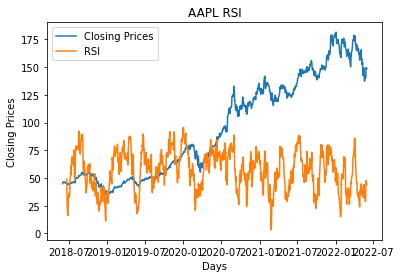

In [9]:
closing_prices = df['Close']
symbol="AAPL"

# Plot the data

plt.title(symbol + ' RSI')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(rs, label='RSI')
plt.legend()
plt.show()

###MACD

In [10]:
def MACD(df,st=12,lt=26,tg=9):
  df_macd = df.copy()
  # Get the 12-day EMA of the closing price
  k = df_macd['Close'].ewm(span=st, adjust=False, min_periods=st).mean()
  # Get the 26-day EMA of the closing price
  d = df_macd['Close'].ewm(span=lt, adjust=False, min_periods=lt).mean()
  # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
  df_macd['diff'] = k - d
  # Get the 9-Day EMA of the MACD for the Trigger line
  df_macd['macd'] = df_macd['diff'].ewm(span=tg, adjust=False, min_periods=tg).mean()
  return df_macd

In [11]:
df_macd = MACD(df,12,26,9)
df_macd.dropna(inplace=True)

def ind(df):
  norm = []
  for i in range(1,len(df)):
    if df['diff'].iloc[i-1]<df['macd'].iloc[i-1] and df['diff'].iloc[i]>df['macd'].iloc[i]:
      norm.append(0)
    elif df['diff'].iloc[i-1]>df['macd'].iloc[i-1] and df['diff'].iloc[i]<df['macd'].iloc[i]:  
      norm.append(1)
    else:
      norm.append(2)
  return norm      
   
norm = ind(df_macd)
df_macd = df_macd.iloc[1:]
df_macd['macnorm'] = norm
df_macd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,diff,macd,macnorm
Date,,,,,,,,
2018-07-19,45.591132,46.278520,45.591132,46.117489,81147200,0.240546,0.111263,2
2018-07-20,46.093451,46.249674,45.706494,46.011734,82704800,0.253904,0.139791,2
2018-07-23,45.829078,46.136723,45.559892,46.052601,63957600,0.264736,0.164780,2
2018-07-24,46.254490,46.545310,46.158353,46.386681,74791600,0.296856,0.191195,2
2018-07-25,46.401102,46.831322,46.249683,46.824112,66839600,0.353533,0.223663,2
...,...,...,...,...,...,...,...,...
2022-05-24,140.809998,141.970001,137.330002,140.360001,104132700,-6.360882,-5.604575,2
2022-05-25,138.429993,141.789993,138.339996,140.520004,92482700,-6.255340,-5.734728,2
2022-05-26,137.389999,144.339996,137.139999,143.779999,90601500,-5.841309,-5.756044,2


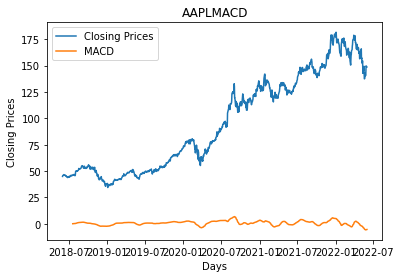

In [12]:
closing_prices = df['Close']
symbol="AAPL"

# Plot the data

plt.title(symbol + 'MACD')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(df_macd['macd'], label='MACD')
plt.legend()
plt.show()

### Bollinger Bands

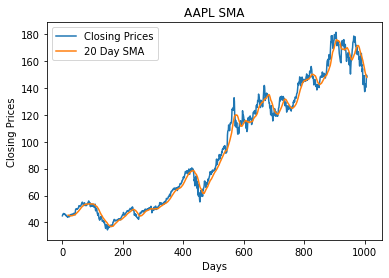

In [15]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

symbol = 'AAPL'
#df = pdr.DataReader(symbol, 'yahoo', '2014-07-01', '2015-07-01') # <-- Get price data for stock from date range
df.index = np.arange(df.shape[0]) # Convert the index to array from [0, 1, 2, ...number of rows]
closing_prices = df['Close'] # Use only closing prices

sma = get_sma(closing_prices, 20) # Get 20 day SMA

# Plot the data
plt.title(symbol + ' SMA')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(sma, label='20 Day SMA')
plt.legend()
plt.show()

In [16]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

symbol = 'AAPL'
#df = pdr.DataReader(symbol, 'yahoo', '2014-07-01', '2015-07-01')
df.index = np.arange(df.shape[0])
closing_prices = df['Close']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

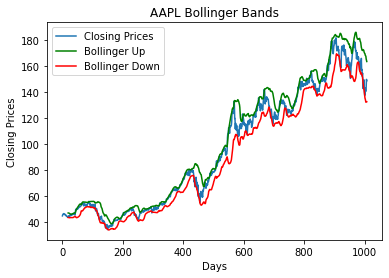

In [17]:
plt.title(symbol + ' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()